# $\textbf{Devoir 1}$

$\textbf{Par Lucky Khounvongsa (20172476), Roman Nakhuda (20207082) et Ange Lilian Tchomtchoua Tokam ()}$

## $\textbf{Question 1}$

$\textbf{En prenant}$ $x_1$ $\textbf{comme le nombre d'acres de tomates et}$ $x_2$ $\textbf{comme le nombre d'acres de maïs,}$


$\textbf{On obtient le probleme mathematique suivant;}$

\begin{align*}
  \max\            & 30x_1+15x_2 \\
  \text{sujet à } &   x_1 +x_2 ≤ 350 &   \text{:pour les acres} \\
                  &   3x_1 + x_2 ≤ 480 &   \text{:pour les heures} \\
                  &   x_1, x_2 \geq 0
\end{align*}

$\textbf{Que l'on peut convertir en un problème de minimisation}$

$\textbf{à l'introduction des variables d'écart u et v, on a;}$

\begin{align*}
  \ -min\            & -30x_1-15x_2 \\
  \text{sujet à } &   x_1 +x_2 +u = 350 \\
                  &    3x_1 + x_2 +v = 480 \\
                  &    x_1, x_2, u, v \geq 0
\end{align*}

- $\textbf{Resolution sous forme Graphique}$

In [1]:
using JuMP, HiGHS, Plots

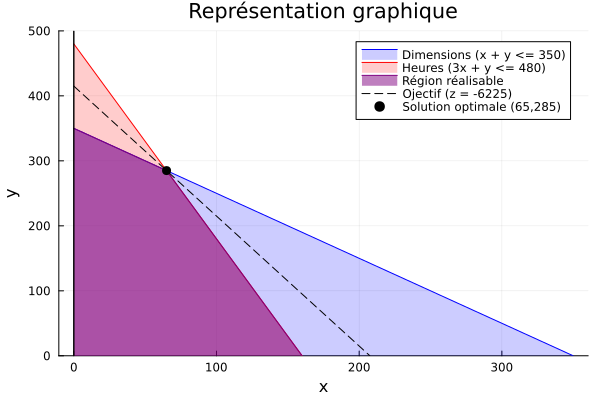

In [2]:
#Premiere contrainte
plot(x-> 350-x, 0, 350, fill = (0, 0.2, :blue), color = :blue, label = "Dimensions (x + y <= 350)")
#Deuxieme contrainte
plot!(x-> 480-3x, 0, 480/3, fill = (0, 0.2, :red), color = :red, label = "Heures (3x + y <= 480)")
plot!(x-> min(350-x, 480-3x), 0, 350, 
    fill = (0, 0.5, :purple), color = :purple, label = "Région réalisable")
vline!([0,0], color = :black, label = "")
plot!(ylims = (0, 500))
plot!(x -> (6225 - 30*x)/15, color = :black, label = "Ojectif (z = -6225)", linestyle = :dash)
scatter!([65], [285], label = "Solution optimale (65,285)", color = :black, markersize = 5)

plot!(xlabel = "x", ylabel = "y")
plot!(title = "Représentation graphique")

$\textbf{D'où la solution optimale en}$ $x = 65$ et $y = 285$, $\textbf{avec}$ $z = 6225$

- $\textbf{Resolution avec les librairies JuMP et HiGHS}$

In [3]:
using HiGHS, JuMP

In [4]:
m = Model(HiGHS.Optimizer)

@variable(m, x >= 0)
@variable(m, y >= 0)

@constraint(m, x + y <= 350)
@constraint(m, 3x + y <= 480)

@objective(m, Max, 30x+15y);

print(m)

In [5]:
status = optimize!(m)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
2 rows, 2 cols, 4 nonzeros
2 rows, 2 cols, 4 nonzeros
Presolve : Reductions: rows 2(-0); columns 2(-0); elements 4(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -4.4999962776e+01 Ph1: 2(6); Du: 2(45) 0s
          2     6.2250000000e+03 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  6.2250000000e+03
HiGHS run time      :          0.00


In [6]:
[value(x), value(y)]

2-element Vector{Float64}:
  65.0
 285.0

- $\textbf{Resolution avec Julia grace à la fonction du simplexe}$

In [7]:
function pivot!(M::Matrix, i::Int, j::Int)
    m, n = size(M)
    @assert M[i, j] != 0
    M[i, :] = M[i, :]/M[i, j]
    for k in setdiff(1:m, i)
        M[k, :] -= M[k, j] * M[i, :]
    end
    return M
end

function getReducedCosts(M::Matrix)
    m, n = size(M)
    return M[end, 1:n-1]
end
function getxB(M::Matrix)
    m, n = size(M)
    return M[1:m-1, end]
end
function enteringVar(M::Matrix)
    rc = getReducedCosts(M)
    index = argmin(rc)
    return rc[index] >= 0 ? -1 : index
end
function exitingVarIndex(M::Matrix{T}, enteringVar::Int) where T
    col = M[1:end-1, enteringVar]
    xB = getxB(M)
    m, n = size(M)
    index = -1
    val = T(Inf)
    for i in 1:m-1
        if (col[i] > 0) && (xB[i]/col[i] < val)
            val = xB[i]/col[i]
            index = i
        end
    end
    return index
end
function isOneHot(v::Vector)
    n = length(v)
    return (sum(iszero, v) == n-1) && (sum(isone, v) == 1)
end 
function isoptimal(M)
    return enteringVar(M) == -1
end
function findInitialBasis!(M::Matrix)
    m, n = size(M)
    m-=1
    n-=1
    basis = [-1 for _ in 1:m]
    for i in 1:n
        if isOneHot(M[1:end-1, i])
            index = findfirst(isone, M[:, i])
            basis[index] = i
        end
    end
    @assert !any(t-> t == -1, basis) "problem not caconical"
    for i in 1:m
        j = basis[i]
        pivot!(M, i, j)
    end
    return basis
end
function simplexSolver(A::Matrix{T}, b::Vector, c::Vector; verbose::Bool = false) where T
    M = [A b; c' 0]
    basis = findInitialBasis!(M)
    k = 1
    nmax = 1000
    while !isoptimal(M) && k < nmax
        k+=1
        verbose && display(M)
        entering = enteringVar(M)
        entering == -1 && (println("------------"); return T[-1, -1])
        leaving = exitingVarIndex(M, entering)
        leaving == -1 && (println("------------"); return T[-1, -1])
        verbose && @show (entering, leaving)
        basis[leaving] = entering
        pivot!(M, leaving, entering)
    end
    verbose && display(M)
    m, n = size(M)
    xstar = zeros(T, n - 1)
    xstar[basis] = getxB(M)
    return xstar
end

simplexSolver (generic function with 1 method)

In [8]:
A=[1//1 1 1 0 ; 
    3 1 0 1;
]
b=[350, 480]
c = [-30, -15,0,0]

4-element Vector{Int64}:
 -30
 -15
   0
   0

In [9]:
simplexSolver(A, b, c, verbose=true)

3×5 Matrix{Rational{Int64}}:
   1//1    1//1  1//1  0//1  350//1
   3//1    1//1  0//1  1//1  480//1
 -30//1  -15//1  0//1  0//1    0//1

(entering, leaving) = (1, 2)


3×5 Matrix{Rational{Int64}}:
 0//1   2//3  1//1  -1//3   190//1
 1//1   1//3  0//1   1//3   160//1
 0//1  -5//1  0//1  10//1  4800//1

(entering, leaving) = (2, 1)


3×5 Matrix{Rational{Int64}}:
 0//1  1//1   3//2  -1//2   285//1
 1//1  0//1  -1//2   1//2    65//1
 0//1  0//1  15//2  15//2  6225//1

4-element Vector{Rational{Int64}}:
  65//1
 285//1
   0//1
   0//1

## $\textbf{Question 2}$

$\textbf{Soit le problème écrit au long :}$
\begin{align*}
  \min\           & c_1x_1+\dots+c_nx_n \\
  \text{tel que } &   a_1x_1 +\dots+a_nx_n ≤ b \\
                  &   x_1,\dots, x_n \geq 0
\end{align*}

 $\textbf{On considère}$ $x_k$ $\textbf{comme la variable de base du problème avec}$ ${A = (a_1 \dots a_k \dots a_n)}.$ 

$\textbf{Comme}$ $x_k$ $\textbf{est l'unique variable de base du problème nous avons : }$

$ B = (a_k) \implies B^{-1} = \frac{1}{a_k}$

$\textbf{On a donc : }$ $Ax = b \implies Bx_b = b \implies x_b = bB^{-1} \implies x_k = \frac{b}{a_k} $

\begin{align*}&
Où & X = \begin{pmatrix}
      x_b & 0
\end{pmatrix}
=
\begin{pmatrix}
0 \\
\vdots \\
\frac{b}{a_k} \\
\vdots \\
0
\end{pmatrix}
\end{align*}

$\textbf{C'est une solution de base non dégénérée puisque}$ $b>0$ $\textbf{et}$ $a_k$>0  $\textbf{(1)}$

$\textbf{On a que l'indice k satisfait la relation}$ $\frac{c_k}{a_k} = \underset{j = 1, \dots, n}\min \{\frac{c_j}{a_j}\}$



$\textbf{Par le fait que }$ $\frac{c_k}{a_k}$ $\textbf{est le}$ $\underset{j = 1, \dots, n}\min \{\frac{c_j}{a_j}\}$ $\textbf{et  par (1) on a ainsi :}$

 $z =  c_k \frac{b}{a_k} = \frac{c_k}{a_k} * b$ 

$\textbf{Puisque}$ $b$ $\textbf{est constant et qu'il apparaît pour toute solutions de base non dégénérée,}$
$\textbf{on peut se concentrer uniquement sur la valeur de}$ $\frac{c_j}{a_j}$.
$\textbf{afin d'évaluer la fonction objective.}$

$\textbf{Donc comme}$ $\frac{c_k}{a_k}$ $\textbf{est le}$ $\underset{j = 1, \dots, n}\min \{\frac{c_j}{a_j}\}$
$\textbf{alors la solution est optimale pour}$ $\frac{c_k}{a_k.}$

$\textbf{X est bien une solution de base optimale non dégénérée puisque}$ $z$ $\textbf{est minimisé lorsqu'on choisi}$ $x_k$ $\textbf{comme variable de base.}$

$\textbf{Par le théorème fondamentale de la programmation linéaire, c'est aussi une solution optimale du problème.}$

## $\textbf{Question 3}$

$\textbf{Soit}$ $K =\{x | Ax = b, x \geq 0 \}$ $\textbf{et K est non vide}$

### $\textbf{Corollaire 1:}$

$\textbf{Montrons que si l'ensemble convexe K est non vide, alors il existe au moins un point extrême.}$

##### $\textbf{Par définition d'un ensemble convexe non vide,}$ $\textbf{chaque}$ $x \in k$ $\textbf{peut s'écrire comme combinaison convexe de deux points}$ $x_1, x_2 \in k$ $\textbf{tels que}$ $x= \alpha x_1 + (1-\alpha)x_2, \alpha \in [0,1]$

##### $\textbf{Par définition d'un point extrême,}$ $\textbf{chaque x est un point extrême de k s'}$ $\textbf{il n'existe pas de deux points}$ $x_1, x_2 \in k$ $\textbf{tels que}$ $x= \alpha x_1 + (1-\alpha)x_1 , \alpha \in ]0,1[$

$\textbf{Notons}$ $S$ $\textbf{l'ensemble des points qui respectent;}$

$x= \alpha x_1 + (1-\alpha)x_2,$ $\textbf{avec}$ $x_1, x_2 \in k$ $\textbf{et}$ $\alpha \in ]0,1[$

$\textbf{Ainsi,}$ $S \subseteq k$ $\textbf{, or}$ $k \setminus S \neq ∅$ $\textbf{, car}$ $\exists $x $\in $k $\textbf{ tel que}$ $x= \alpha x_1 + (1-\alpha)x_2$ $\textbf{, pour}$ $x_1, x_2 \in k$ $\textbf{et}$ $\alpha = 0$ ou $\alpha = 1$ 

$\textbf{Ainsi lorsqu'on prend l'ensemble}$ $K$ $\textbf{privé de tous les points qui ne sont pas des points extremes, }$ $\textbf{on aura un ensemble resultant qui est non-vide.}$

$\textbf{Par conséquent, si l'ensemble convexe}$ $K$ $\textbf{est non-vide, alors il y a au moins un point extrême.}$

### $\textbf{Corollaire 2:}$

$\textbf{Par le théorème fondamentale de la programmation linéaire, nous savons que s'il y a une solution optimale réalisable,}$ $\textbf{alors il y a une solution de base réalisable optimale.}$

$\textbf{Ainsi, s'il existe une solution optimale finie à un problème, alors il existe une solution optimale finie de base à ce problème.}$

$\textbf{On pose ainsi le vecteur}$ $x $\* $\textbf{dans}$ $Ax^{*} = b$ $\textbf{et}$ $x^{*}\geq 0$ $\textbf{, une solution de base optimale de ce problème.}$

$\textbf{Or}$ $x $\* $\textbf{est une solution de base réalisable si et seulement si}$ $x $\* $\textbf{est un point extrême.}$

$\textbf{Ainsi il existe bien une solution optimale finie qui est un point extrême.}$

## $\textbf{Question 4}$

$\textbf{Soit}$
\begin{align*}
  \min\           & c^Tx \\
  \text{tel que } &   Ax = b, x \geq 0
\end{align*}

$\textbf{a) Montrons que d direction réalisable}$ $\implies Ad = 0$

\begin{align*}
& A( x + \alpha d) = b \\ 
& Ax + A(\alpha d) = b  &(dévelopement)\\
& b + A(\alpha d)  = b  &(Ax =b)\\
& A(\alpha d)      = 0  &(-b)\\
& Ad = 0                &(\div\alpha)            
\end{align*}

\begin{align*}
&&&&&&&&&&&&&&&&&&&&&&&&&&&& \ QED
\end{align*}

$\textbf{b) Nous pouvons écrire l'inégalité pour les points réalisables}$

\begin{align*}C^T x^* \leq C^T x \end{align*}

$\textbf{Il existe}$ $\alpha \gt 0$ $\textbf{tel que}$ $x$ $= x^*$ + $\alpha d$
$\textbf{On sait que}$
\begin{align*}
    \begin{aligned}Ax^* = b \implies & A(x- \alpha d) = b\\
        & Ax - A \alpha d = b \\
        & Ax = b 
    \end{aligned}
\end{align*}

$\textbf{On a x donc réalisable, qui nous donne;}$

\begin{align*}
    \implies & C^Tx^* \leq C^Tx \\
    & C^Tx^* \leq C^T(x^* +\alpha d) &(ici,  x = x^* + \alpha d) \\
    & C^Tx^* \leq C^Tx^* + C^T \alpha d &(Dévelopement) \\
    & 0 \leq C^T \alpha d &(-C^T x^*) \\
    & 0 \leq C^T d &(\div \alpha)
\end{align*}

\begin{align*}
&&&&&&&&&&&&&&&&&&&&&&&& \ QED
\end{align*}